In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# Discount Factor

Money paid today is not the same as money paid in one year (Try staying without eating 1 year!).

$$P_{\rm today} = P_{\rm tomorrow} \times D(\tau,r),$$

where $D$ is a discount factor that depends on: 

1. The temporal distance between _today_ and _tomorrow_, $\tau$.   
   The temporal distance, $\tau$, is not equivalent to substract the dates of two days but depends on [conventions](https://en.wikipedia.org/wiki/Day_count_convention). Pay attention to these when pricing!    
2. The _risk-free_ interest rate, $r$.    
   The interest rate, $r$, is a theoretical quantity. LIBOR and LIBOR-swap rates have been good proxies in the past, however, [Hull](http://www-2.rotman.utoronto.ca/~hull/DownloadablePublications/LIBORvsOIS.pdf) suggests that, from 2007 on, the overnight indexed swap (OIS) rates should be used instead.
3. Its own functional form ([wiki](https://en.wikipedia.org/wiki/Discounting))! 
   The continuously-compounded hypothesis is an approximation that does not have any real application as no financial instrument is continuously compounded.
   
We will use:

$$\tau={\rm year_b - year_a}$$

$$D(\tau,r) = e^{-r \, \tau}$$

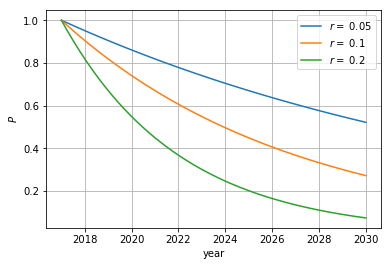

In [2]:
def discount_factor(t_now,t_future,risk_free_rate):
    r = risk_free_rate
    t = t_now
    T = t_future
    return np.exp(-r * (T-t) )

P_today = 1.0 #value of money today
t_now = 2017 #in years
t_tomorrow = 2030 #in years
t = np.linspace(t_now,t_tomorrow)

for ir in [0.05,0.1,0.2]: #risk-free rate
    P_tomorrow = discount_factor(t_now,t,ir)
    plt.plot(t,P_tomorrow,label="$r =$ "+ str(ir))
    
plt.grid()
plt.xlabel("year")
plt.ylabel("$P$")
plt.legend()
plt.show()


# Bonds

When you buy a bond you are basically buying money in the future. Suppose you want to buy _today_ a bond that each year $t_i$ pays you a quantity $C_i$ (These are called _coupons_) and a quantity $P$ (This is called _principal_) the year $T$ (The _maturity_). The _"naive value"_, $V_{\rm naive}$, of such a contract is just the amount of money you will get in the future discounted to the present, $t_0$:

$$
V_{\rm naive} = P \, e^{ -r \, ( T - t_0 ) } + \sum_{t_1}^{T}{ C_i \, e^{ -r \, ( t_i - t_0 ) } }.
$$

In practice, to compensate for the risk of investment (e.g. default risk, currency risk, and inflation risk), the issuer must make the contract more attractive by lowering its price: $V_{\rm bond} < V_{\rm naive}$. Thus, given the same principal and coupons, we must change the risk-free rate $r$ by some other quantity, $y$:

\begin{equation}
V_{\rm bond} = P \, e^{ -y \, ( T - t_0 ) } + \sum_{t_1}^{T}{ C_i \, e^{ -y \, ( t_i - t_0 ) } }.
\end{equation}

The quantity $y$ is called the _yield to maturity_ or _internal rate of return_ of the bond. In the simple case of a zero coupon bond ($C_i = 0$), the yield to maturity is easily calculated: 

\begin{equation}
y = -\frac{ \log {(V_{\rm bond} \, / \, P)} }{T-t_0}.
\end{equation}

On the other hand, if the bond has coupons, $y$ must be found by some trial and error (done in a smart way preferably!) that gives the correct value of $V_{\rm bond}$.

The yield to maturity, $y$, is a measure useful to compare bonds with different coupons and market values. 

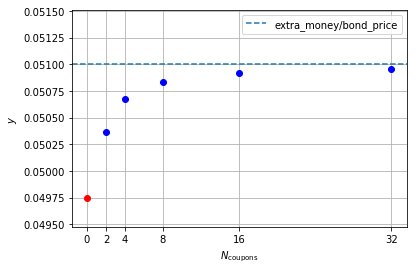

In [3]:
def __present_value_coupon_bond__(ytm,principal,maturity,present_time,coupons=None,coupon_dates=None):
    P = principal
    Ci = coupons
    T = maturity
    t = present_time
    ti = coupon_dates
    y = ytm
    
    principal_value = P * np.exp( - y * ( T - t ) )
    
    if coupons is None and coupon_dates is None:
        return principal_value
    
    else:
        
        if t > min(ti):
            raise Exception("Present time ahead of coupon dates.")
    
        if len(Ci) != len(ti):
            raise Exception("lenghts of coupons and coupon dates differ.")
    
        coupons_value = sum([Ci[i] * np.exp( -y * ( ti[i] - t ) ) for i in range(len(Ci))])
        
        return principal_value + coupons_value

def yield_to_maturity(present_value,principal,maturity,present_time,coupons=None,coupon_dates=None):
    """
    Present value should be 0 < Z < P = principal
    Present time should be t < T = maturity
    """
    P = principal
    T = maturity
    Z = present_value
    t = present_time
    Ci = coupons
    ti = coupon_dates
    
    yp = - np.log(Z/P)/(T-t)
    
    if coupons is None and coupon_dates is None:
        return yp

    else:
        
        if t > min(ti):
            raise Exception("Present time ahead of coupon dates.")
    
        if len(Ci) != len(ti):
            raise Exception("lenghts of coupons and coupon dates differ.")
            
        fun = lambda y: __present_value_coupon_bond__(y,P,T,t,Ci,ti) - Z
                                                 
        ytm = scipy.optimize.fsolve(fun,Z/P*1e-4)
        
        return ytm

#
#Suppose that two bonds with the same present value and the same maturity are trading... 
#
present_value = 1000.0 #The bond is sold at this price
present_time = 2017.0  #At the present time (in years)
maturity = 2018.0      #With this date of maturity (in years)
extra_money = 51.0     #The bond will give you "extra" money in the future


    
#The Zero coupon bond gives you the "extra" money at maturity:
principal = present_value + extra_money 
y = yield_to_maturity(present_value,principal,maturity,present_time,coupons=None,coupon_dates=None)
plt.plot(0,y,'ro')

#Coupon-bearing bonds give you the "extra" money divided in coupons:
principal = present_value
N_array = np.array([0,2,4,8,16,32])

for Ncoupons in N_array[1:]:
    
    coupons = extra_money/Ncoupons * np.ones(Ncoupons)
    delta_t = (maturity - present_time) / float(len(coupons))
    coupon_dates = np.linspace(present_time+delta_t,maturity,len(coupons))
    
    y = yield_to_maturity(present_value,principal,maturity,present_time,coupons,coupon_dates)
    
    plt.plot(Ncoupons,y,'bo')
    
plt.grid()
plt.xlabel("$N_{\\rm coupons}$")
plt.ylabel("$y$")
plt.xticks(N_array)
plt.axhline(y=extra_money/present_value,linestyle='--',label="extra_money/bond_price")
plt.ylim(extra_money/present_value*np.array([0.97,1.01]))
plt.legend()

plt.show()

# Bonds - Price Yield Relationship

All other parameters equal,

  - the lower the price $V_{\rm bond}$, the higher the yield.
  - the shorter the time to maturity, $T-t_0$, the higher the yield.
  
  
In the plot below Price-Yield relationships are shown:

  - different colors represent different times to maturity, $T-t_0$.
  - different linestyles represent different principals, $P$.


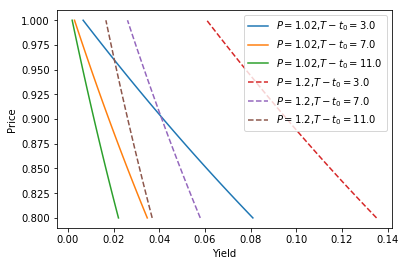

In [4]:
#
#Bonds with the same principal 
#
present_value = np.linspace(0.8,1.0) #The bond is sold at this price
present_time = 2017.0  #At the present time (in years)

principal = 1.02
for maturity in range(2020,2031,4):      #With this date of maturity (in years)

    time_to_maturity = maturity - present_time
    y = yield_to_maturity(present_value,principal,maturity,present_time,coupons=None,coupon_dates=None)
    plt.plot(y,present_value,'-',label="$P=${},$T-t_0=${}".format(principal,time_to_maturity))

    
principal = 1.2
for maturity in range(2020,2031,4):      #With this date of maturity (in years)

    time_to_maturity = maturity - present_time
    y = yield_to_maturity(present_value,principal,maturity,present_time,coupons=None,coupon_dates=None)
    plt.plot(y,present_value,'--',label="$P=${},$T-t_0=${}".format(principal,time_to_maturity))
    
plt.legend()
plt.xlabel("Yield")
plt.ylabel("Price")
plt.show()

# Bonds - Duration

We want to call the _Duration_ of a contract the interval between its start and its maturity. For a zero coupon bond this is trivially defined, $T-t_0$



In the expression for the duration the time of each coupon payment is weighted by its present value

\begin{equation}
-\frac{1}{V_{\rm bond}}\frac{dV_{\rm bond}}{dy} = - P/V_{\rm bond} \, ( T - t_0 ) \, e^{ -y \, ( T - t_0 ) } - \sum_{t_1}^{T}{ C_i/V_{\rm bond} \, ( t_i - t_0 ) \, e^{ -y \, ( t_i - t_0 ) } } \simeq \bar{T} - t_0.
\end{equation}

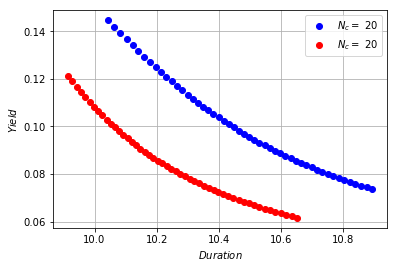

In [5]:
def duration(present_value,principal,maturity,present_time,coupons=None,coupon_dates=None):
    P = principal
    Ci = coupons
    T = maturity
    t = present_time
    ti = coupon_dates
    ytm = yield_to_maturity(present_value,principal,maturity,present_time,coupons,coupon_dates)
    
    V_ = 1.0/present_value
    dcoup = sum([Ci[i] * ( t - ti[i] ) * np.exp( -ytm * ( ti[i] - t ) ) for i in range(len(Ci))])
    dp = P * ( t - T ) * np.exp( -y * ( T - t ) )
    
    ndur = dcoup * V_ + dp * V_
    
    return  - ndur

###
# Duration
###

#Bond 1:

present_value = 2.0 * ( 1.0 + np.linspace(0.0, 1.0) ) #The bond is sold at this price
present_time = 2017.0  #At the present time (in years)
maturity = 2027.0      #With this date of maturity (in years)
extra_money = 3.0     #The bond will give you "extra" money in the future
Ncoupons = 20

principal = present_value 
coupons = extra_money/Ncoupons * np.ones(Ncoupons)
delta_t = (maturity - present_time) / float(len(coupons))
coupon_dates = np.linspace(present_time+delta_t,maturity,len(coupons))

dur = duration(present_value,principal,maturity,present_time,coupons,coupon_dates)
ytm = yield_to_maturity(present_value,principal,maturity,present_time,coupons,coupon_dates)

plt.plot(dur,ytm,'bo',label="$N_c = $ {}".format(Ncoupons))

#Bond 2:

present_value = 2.0 * ( 1.0 + np.linspace(0.0, 1.0) ) #The bond is sold at this price
present_time = 2017.0  #At the present time (in years)
maturity = 2027.0      #With this date of maturity (in years)
extra_money = 2.5    #The bond will give you "extra" money in the future
Ncoupons = 20

principal = present_value
coupons = extra_money/Ncoupons * np.ones(Ncoupons)
delta_t = (maturity - present_time) / float(len(coupons))
coupon_dates = np.linspace(present_time+delta_t,maturity,len(coupons))

dur = duration(present_value,principal,maturity,present_time,coupons,coupon_dates)
ytm = yield_to_maturity(present_value,principal,maturity,present_time,coupons,coupon_dates)

plt.plot(dur,ytm,'ro',label="$N_c = $ {}".format(Ncoupons))

plt.grid()
plt.xlabel("$Duration$")
plt.ylabel("$Yield$")
plt.legend()
plt.show()

# Bonds - Convexity

\begin{equation}
\frac{1}{V_{\rm bond}}\frac{d^2V_{\rm bond}}{dy^2} 
\end{equation}

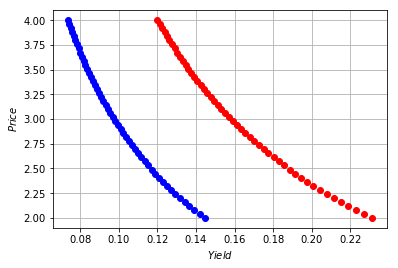

In [6]:
def convexity(present_value,principal,maturity,present_time,coupons=None,coupon_dates=None):
    P = principal
    Ci = coupons
    T = maturity
    t = present_time
    ti = coupon_dates
    ytm = yield_to_maturity(present_value,principal,maturity,present_time,coupons,coupon_dates)
    
    V_ = 1.0/present_value
    dcoup = sum([Ci[i] * np.power( t - ti[i], 2 ) * np.exp( -ytm * ( ti[i] - t ) ) for i in range(len(Ci))])
    dp = P * np.power( t - T,2 ) * np.exp( -ytm * ( T - t ) )
    
    convex = dcoup * V_ + dp * V_
    
    return  convex

###
# Convexity
###

#Bond 1:

present_value = 2.0 * ( 1.0 + np.linspace(0.0, 1.0) ) #The bond is sold at this price
present_time = 2017.0  #At the present time (in years)
maturity = 2027.0      #With this date of maturity (in years)
extra_money = 3.0     #The bond will give you "extra" money in the future
Ncoupons = 20

principal = present_value 
coupons = extra_money/Ncoupons * np.ones(Ncoupons)
delta_t = (maturity - present_time) / float(len(coupons))
coupon_dates = np.linspace(present_time+delta_t,maturity,len(coupons))

cvx = convexity(present_value,principal,maturity,present_time,coupons,coupon_dates)
ytm = yield_to_maturity(present_value,principal,maturity,present_time,coupons,coupon_dates)

plt.plot(ytm,present_value,'bo')


#Bond 2:

present_value = 2.0 * ( 1.0 + np.linspace(0.0, 1.0) ) #The bond is sold at this price
present_time = 2017.0  #At the present time (in years)
maturity = 2027.0      #With this date of maturity (in years)
extra_money = 5.0    #The bond will give you "extra" money in the future
Ncoupons = 15

principal = present_value
coupons = extra_money/Ncoupons * np.ones(Ncoupons)
delta_t = (maturity - present_time) / float(len(coupons))
coupon_dates = np.linspace(present_time+delta_t,maturity,len(coupons))

cvx = convexity(present_value,principal,maturity,present_time,coupons,coupon_dates)
ytm = yield_to_maturity(present_value,principal,maturity,present_time,coupons,coupon_dates)

plt.grid()
plt.plot(ytm,present_value,'ro')
plt.xlabel("$Yield$")
plt.ylabel("$Price$")
plt.show()

# Options Call & Put - Black and Scholes

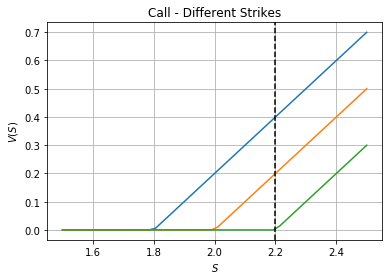

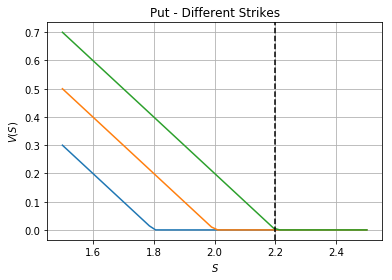

In [7]:
def BSCall(stock_price, time_now, strike, expiry, risk_free_rate, volatility, dividend):
    if np.any(np.array(time_now - expiry) > 0):
        raise ValueError("Expiry in the past!")
    
    S = stock_price
    E = strike
    t = time_now
    T = expiry
    r = risk_free_rate
    sigma = volatility
    D = dividend
    
    d1num = np.log(S/E) + ( r - D + 0.5 * sigma**2 ) * ( T - t )
    d1den = sigma * np.sqrt(T-t)
    d1 = d1num / d1den
    d2 = d1 - sigma * np.sqrt(T-t)
    
    NormalCum = lambda x: 0.5 * ( 1.0 + scipy.special.erf( x/np.sqrt(2) ) )
    
    return S * np.exp( -D * (T-t) ) * NormalCum(d1) - E * np.exp( -r * (T-t) ) * NormalCum(d2)

def BSPut(stock_price, time_now, strike, expiry, risk_free_rate, volatility, dividend):
    if np.any(np.array(time_now - expiry) > 0):
        raise ValueError("Expiry in the past!")
    
    S = stock_price
    E = strike
    t = time_now
    T = expiry
    r = risk_free_rate
    sigma = volatility
    D = dividend
    
    d1num = np.log(S/E) + ( r - D + 0.5 * sigma**2 ) * ( T - t )
    d1den = sigma * np.sqrt(T-t)
    d1 = d1num / d1den
    d2 = d1 - sigma * np.sqrt(T-t)
    
    NormalCum = lambda x: 0.5 * ( 1.0 + scipy.special.erf( x/np.sqrt(2) ) )
    
    return - S * np.exp( -D * (T-t) ) * NormalCum(-d1) + E * np.exp( -r * (T-t) ) * NormalCum(-d2)


stock_price = np.linspace(1.5,2.5)
time_now = 0.99999
strike = 2.0
expiry = 1.0
volatility = 0.5
dividend = 0.0
risk_free_rate = 0.1

for strike in [1.8,2.0,2.2]:
      
    bs = BSCall(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.title("Call - Different Strikes")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-')
        
plt.grid()
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()

for strike in [1.8,2.0,2.2]:
      
    bs = BSPut(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.title("Put - Different Strikes")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-')
        
plt.grid()
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()

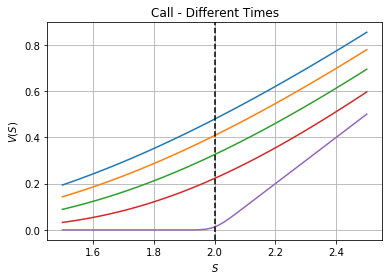

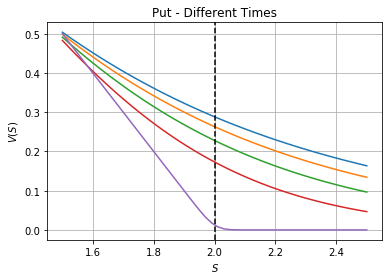

In [8]:
stock_price = np.linspace(1.5,2.5)
strike = 2.0
expiry = 1.0
volatility = 0.5
dividend = 0.0
risk_free_rate = 0.1
    
#Call - Different Times
for time_now in expiry*np.linspace(0.0,1.0-1.0/1024,5):
      
    bs = BSCall(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.title("Call - Different Times")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-')
        
plt.grid()
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()

#Put - Different Times
for time_now in expiry*np.linspace(0.0,1.0-1.0/1024,5):
      
    bs = BSPut(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.title("Put - Different Times")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-')
        
plt.grid()
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()

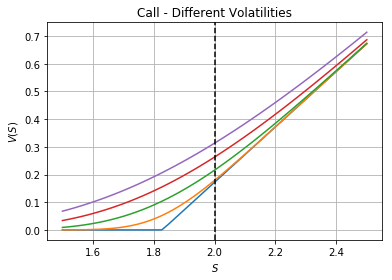

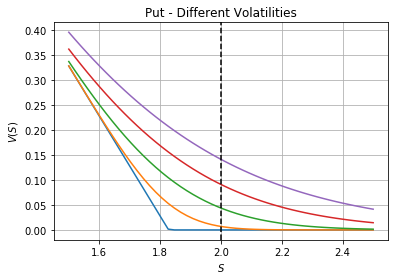

In [11]:
stock_price = np.linspace(1.5,2.5)
time_now = 0.1
strike = 2.0
expiry = 1.0
dividend = 0.0
risk_free_rate = 0.1
    
#Call - Different Times
for volatility in np.linspace(0.001,0.3,5):
      
    bs = BSCall(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.title("Call - Different Volatilities")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-')
        
plt.grid()
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()

#Put - Different Times
for volatility in np.linspace(0.001,0.3,5):
      
    bs = BSPut(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.title("Put - Different Volatilities")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-')
        
plt.grid()
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()

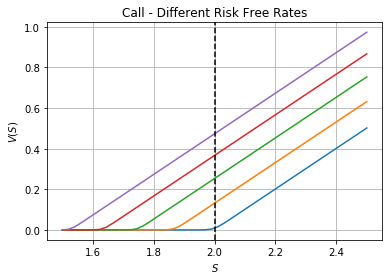

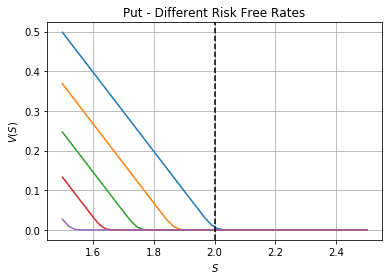

In [14]:
stock_price = np.linspace(1.5,2.5)
time_now = 0.1
strike = 2.0
expiry = 1.0
dividend = 0.0
volatility = 0.01

    
#Call - Different Times
for risk_free_rate in np.linspace(0.001,0.3,5):
      
    bs = BSCall(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.title("Call - Different Risk Free Rates")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-')
        
plt.grid()
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()

#Put - Different Times
for risk_free_rate in np.linspace(0.001,0.3,5):
      
    bs = BSPut(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.title("Put - Different Risk Free Rates")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-')
        
plt.grid()
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()

# Put-Call parity

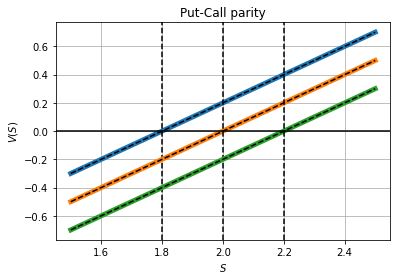

In [15]:
stock_price = np.linspace(1.5,2.5)
time_now = 0.99999
strike = 2.0
expiry = 1.0
volatility = 0.5
dividend = 0.0
risk_free_rate = 0.1

for strike in [1.8,2.0,2.2]:
    
    bs = BSCall(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    bs -= BSPut(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    pcparity = stock_price - strike * discount_factor(time_now,expiry,risk_free_rate)
    plt.title("Put-Call parity")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bs,'-',linewidth=5)
    plt.plot(stock_price,pcparity,'k--')
    
    plt.axvline(x=strike,linestyle='--',color='k')
    
plt.grid()
plt.axhline(y=0,color='k')
plt.show()


# Options - Black and Scholes Straddle

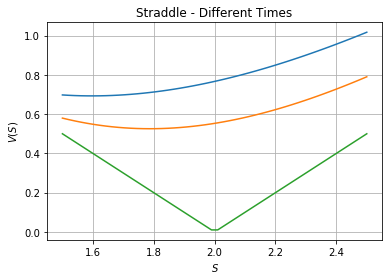

In [16]:
def BSStraddle(stock_price, time_now, strike, expiry, risk_free_rate, volatility, dividend):
    put =  BSPut (stock_price, time_now, strike, expiry, risk_free_rate, volatility, dividend)
    call = BSCall(stock_price, time_now, strike, expiry, risk_free_rate, volatility, dividend)
    return put + call

stock_price = np.linspace(1.5,2.5)
time_now = 0.1
strike = 2.0
expiry = 1.0
volatility = 0.5
dividend = 0.0
risk_free_rate = 0.1

#Straddle - Different Times
for time_now in expiry*np.linspace(0.0,0.99999999,3):
        
    bsC = BSCall(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    bsP = BSPut(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    bsS = bsC + bsP
    plt.title("Straddle - Different Times")
    plt.xlabel("$S$")
    plt.ylabel("$V(S)$")    
    plt.plot(stock_price,bsS,'-')

plt.grid()
plt.show()


# Options - Time Evolution $S < S_{\rm strike}$

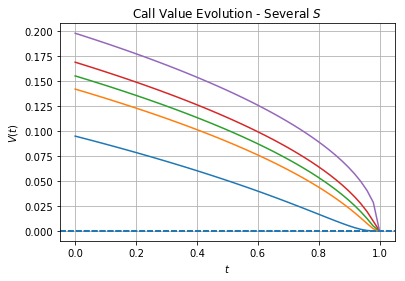

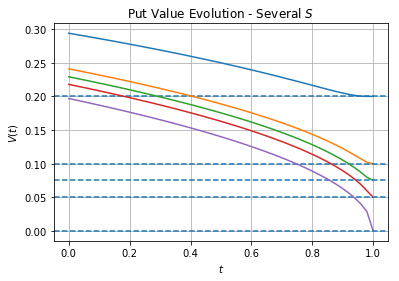

In [19]:
#
# Time evolution of value:
#
strike = 1.0
expiry = 1.0
volatility = 0.5
dividend = 0.0
risk_free_rate = 0.001
t_array = expiry*np.linspace(0.0,0.99999999)


for stock_price in strike * ( 1.0 + np.array([-0.2, -0.1,-0.075,-0.05, -0.0])):
	
	bs = BSCall(stock_price,t_array,strike,expiry,risk_free_rate,volatility,dividend)
	plt.title("Call Value Evolution - Several $S$")
	plt.xlabel("$t$")
	plt.ylabel("$V(t)$")
	plt.plot(t_array,bs,'-')
	plt.axhline(y=max(stock_price-strike,0),linestyle='--')
		
plt.grid()
plt.show()

for stock_price in strike * ( 1.0 + np.array([-0.2, -0.1,-0.075,-0.05, -0.0])):
	
	bs = BSPut(stock_price,t_array,strike,expiry,risk_free_rate,volatility,dividend)
	plt.title("Put Value Evolution - Several $S$")
	plt.xlabel("$t$")
	plt.ylabel("$V(t)$")
	plt.plot(t_array,bs,'-')
	plt.axhline(y=max(-stock_price+strike,0),linestyle='--')
		
plt.grid()
plt.show()



# Options - Time Evolution $S > S_{\rm strike}$

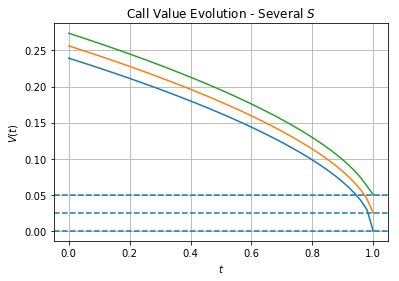

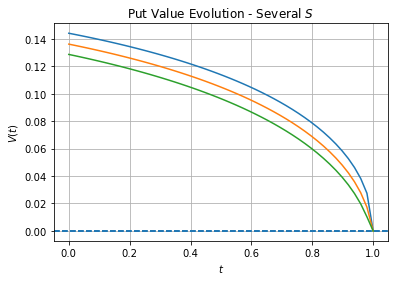

In [165]:
#
# Time evolution of value:
#
strike = 1.0
expiry = 1.0
volatility = 0.5
dividend = 0.0
risk_free_rate = 0.1
t_array = expiry*np.linspace(0.0,0.99999999)


for stock_price in strike * ( 1.0 + np.array([0.0,0.025,0.05])):

	bs = BSCall(stock_price,t_array,strike,expiry,risk_free_rate,volatility,dividend)
	plt.title("Call Value Evolution - Several $S$")
	plt.xlabel("$t$")
	plt.ylabel("$V(t)$")
	plt.plot(t_array,bs,'-')
	plt.axhline(y=max(stock_price-strike,0),linestyle='--')

plt.grid()
plt.show()

#S > S*
for stock_price in strike * ( 1.0 + np.array([0.0,0.025,0.05])):

	bs = BSPut(stock_price,t_array,strike,expiry,risk_free_rate,volatility,dividend)
	plt.title("Put Value Evolution - Several $S$")
	plt.xlabel("$t$")
	plt.ylabel("$V(t)$")
	plt.plot(t_array,bs,'-')
	plt.axhline(y=max(-stock_price+strike,0),linestyle='--')

plt.grid()
plt.show()


# Zero Volatility Limit
## "I know the Stock price in the future $\rightarrow$ The price now must be the discounted Stock Price"

$$
V = S - S_{\rm strike} \, D(T-t,r)
$$

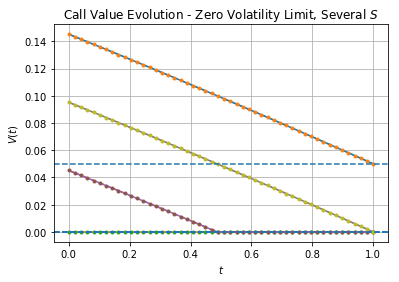

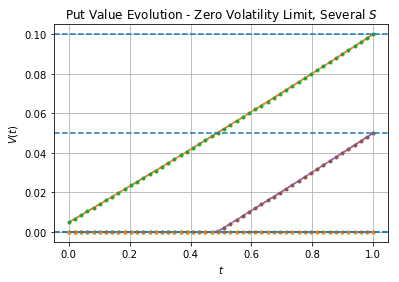

In [166]:
#BS formula reduces to this when Volatility = 0.

strike = 1.0
expiry = 1.0
volatility = 1e-10
dividend = 0.0
risk_free_rate = 0.1
t_array = expiry*np.linspace(0.0,0.99999999)


#Call
for stock_price in strike * ( 1.0 + np.array([-0.1, -0.05,0.0,0.05])):

	stock_strike_difference = stock_price - strike * discount_factor(t_array,expiry,risk_free_rate)
	zero_volatility_limit = np.maximum(stock_strike_difference,0)
	plt.plot(t_array, zero_volatility_limit, '--')

	bs = BSCall(stock_price,t_array,strike,expiry,risk_free_rate,volatility,dividend)
	plt.plot(t_array,bs,'-')
	plt.plot(t_array,zero_volatility_limit,'.')
	plt.axhline(y=max(stock_price-strike,0),linestyle='--')

plt.title("Call Value Evolution - Zero Volatility Limit, Several $S$")
plt.xlabel("$t$")
plt.ylabel("$V(t)$")
plt.grid()
plt.show()

#Put
for stock_price in strike * ( 1.0 + np.array([-0.1, -0.05,0.0,0.05])):

	stock_strike_difference = - stock_price + strike * discount_factor(t_array,expiry,risk_free_rate)
	zero_volatility_limit = np.maximum(stock_strike_difference,0)
	plt.plot(t_array, zero_volatility_limit, '--')

	bs = BSPut(stock_price,t_array,strike,expiry,risk_free_rate,volatility,dividend)
	plt.plot(t_array,bs,'-')
	plt.plot(t_array,zero_volatility_limit,'.')
	plt.axhline(y=max(-stock_price+strike,0),linestyle='--')

plt.title("Put Value Evolution - Zero Volatility Limit, Several $S$")
plt.xlabel("$t$")
plt.ylabel("$V(t)$")
plt.grid()
plt.show()



# Profit / Loss - $S(t_0) < S_{\rm strike}$

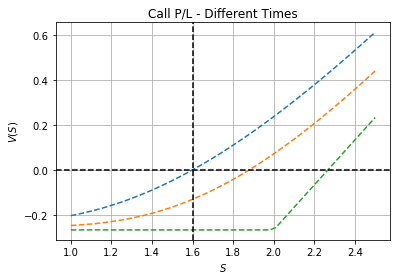

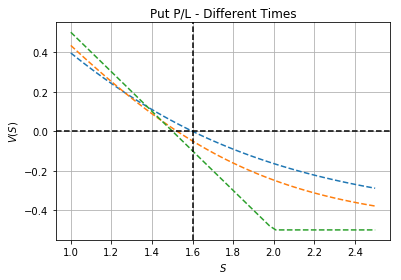

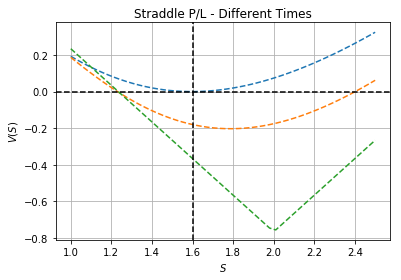

In [168]:
strike = 2.0
expiry = 1.0
volatility = 0.5
dividend = 0.0
risk_free_rate = 0.1
time_buy = 0.0
stock_price_0 = strike * (1.0 - 0.2)
stock_price = np.linspace(1.0,2.5)

#Call
upfront_cost = BSCall(stock_price_0,time_buy,strike,expiry,risk_free_rate,volatility,dividend)    
for time_now in expiry*np.array([0.0,0.5,0.999999]):
	bs = BSCall(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
	profit_over_loss = bs - upfront_cost * discount_factor(time_now,time_buy,risk_free_rate)

	plt.plot(stock_price,profit_over_loss,'--')

plt.title("Call P/L - Different Times")
plt.xlabel("$S$")
plt.ylabel("$V(S)$")
plt.axvline(x = stock_price_0, linestyle = "--", c = 'k')
plt.axhline(y = 0, linestyle = "--", c = 'k')
plt.grid()
plt.show()

#Put
upfront_cost = BSPut(stock_price_0,time_buy,strike,expiry,risk_free_rate,volatility,dividend)
for time_now in expiry*np.array([0.0,0.5,0.999999]):
	bs = BSPut(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
	profit_over_loss = bs - upfront_cost * discount_factor(time_now,time_buy,risk_free_rate)
	plt.plot(stock_price,profit_over_loss,'--')

plt.title("Put P/L - Different Times")
plt.xlabel("$S$")
plt.ylabel("$V(S)$")    
plt.axvline(x = stock_price_0, linestyle = "--", c = 'k')
plt.axhline(y = 0, linestyle = "--", c = 'k')    
plt.grid()
plt.show()

#Straddle
upfront_cost = BSStraddle(stock_price_0,time_buy,strike,expiry,risk_free_rate,volatility,dividend)
for time_now in expiry*np.array([0.0,0.5,0.999999999]):
	bs = BSStraddle(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
	profit_over_loss = bs - upfront_cost * discount_factor(time_now,time_buy,risk_free_rate)
	plt.plot(stock_price,profit_over_loss,'--')

plt.title("Straddle P/L - Different Times")
plt.xlabel("$S$")
plt.ylabel("$V(S)$")    
plt.axvline(x = stock_price_0, linestyle = "--", c = 'k')
plt.axhline(y = 0, linestyle = "--", c = 'k')    
plt.grid()
plt.show()

# Deltas $\Delta = \frac{\partial{V}}{\partial{S}}$

In [23]:
def BSCallDelta(stock_price, time_now, strike, expiry, risk_free_rate, volatility, dividend):
    if np.any(np.array(time_now - expiry) > 0):
        raise ValueError("Expiry in the past!")
    
    S = stock_price
    E = strike
    t = time_now
    T = expiry
    r = risk_free_rate
    sigma = volatility
    D = dividend
    
    d1num = np.log(S/E) + ( r - D + 0.5 * sigma**2 ) * ( T - t )
    d1den = sigma * np.sqrt(T-t)
    d1 = d1num / d1den
    d2 = d1 - sigma * np.sqrt(T-t)
    
    NormalCum = lambda x: 0.5 * ( 1.0 + scipy.special.erf( x/np.sqrt(2) ) )
    
    return np.exp( -D * (T-t) ) * NormalCum(d1)

def BSPutDelta(stock_price, time_now, strike, expiry, risk_free_rate, volatility, dividend):
    if np.any(np.array(time_now - expiry) > 0):
        raise ValueError("Expiry in the past!")
    
    S = stock_price
    E = strike
    t = time_now
    T = expiry
    r = risk_free_rate
    sigma = volatility
    D = dividend
    
    d1num = np.log(S/E) + ( r - D + 0.5 * sigma**2 ) * ( T - t )
    d1den = sigma * np.sqrt(T-t)
    d1 = d1num / d1den
    d2 = d1 - sigma * np.sqrt(T-t)
    
    NormalCum = lambda x: 0.5 * ( 1.0 + scipy.special.erf( x/np.sqrt(2) ) )
    
    return np.exp( -D * (T-t) ) * (NormalCum(d1) - 1.0)

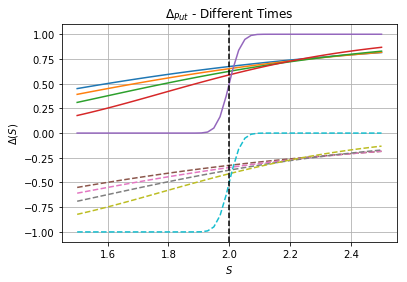

In [28]:
stock_price = np.linspace(1.5,2.5)
strike = 2.0
expiry = 1.0
volatility = 0.5
dividend = 0.0
risk_free_rate = 0.1
    
#Call - Different Times
for time_now in expiry*np.linspace(0.0,1.0-1.0/1024,5):
    bs = BSCallDelta(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend
    plt.plot(stock_price,bs,'-')
        

#Put - Different Times
for time_now in expiry*np.linspace(0.0,1.0-1.0/1024,5):      
    bs = BSPutDelta(stock_price,time_now,strike,expiry,risk_free_rate,volatility,dividend)
    plt.plot(stock_price,bs,'--')

plt.title("$\Delta_{Call}$ and $\Delta_{Put}$ - Different Times")
plt.xlabel("$S$")
plt.ylabel("$\Delta(S)$")    
plt.grid()
plt.ylim([-1.1,1.1])
plt.axvline(x=strike,linestyle='--',color='k')
plt.show()